Example of how to use Markov clustering on HSNE hierarchies

Most of these dependencies are standard toolkit for data scientists, however the Markov clustering library is probably not. I use this implementation: https://github.com/GuyAllard/markov_clustering

In [14]:
from HSNE_parser import read_HSNE_binary
import pandas as pd
import numpy as np

import markov_clustering as mc

import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.cm as cm

from sklearn.metrics import adjusted_rand_score
from sklearn.metrics.cluster import contingency_matrix


Read the hierarchy from a HSNE binary file and print progress:

In [15]:
hsne = read_HSNE_binary(filename="/home/paul/Stage/LDA/Data/MNIST/mnist_no_labels_train.hsne", verbose=True)

Number of scales 4
Start reading first scale of size 60000
Done reading first scale..

Next scale: 1
Scale size: 12005
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..

Next scale: 2
Scale size: 1765
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..

Next scale: 3
Scale size: 128
Reading transmatrix..
Reading landmarks of scale to original data..
Reading landmarks to previous scale..
Reading landmark weights..
Reading previous scale to current scale..
Reading area of influence..
Total time spent parsing hierarchy and building objects: 4.781799


Fetch raw MNIST data & labels

MNIST in CSV format available at: https://pjreddie.com/projects/mnist-in-csv/

In [16]:
# Read mnist data and put labels in seperate array
mnist = pd.read_csv("/home/paul/Stage/LDA/Data/MNIST/mnist_train.csv", header=None)
mnist_data = mnist.drop(columns=0)
mnist_labels = mnist[0].ravel()
del mnist

MNIST are handwritten digits 0-9 with each pixel corresponding to a grey value

Label: 5


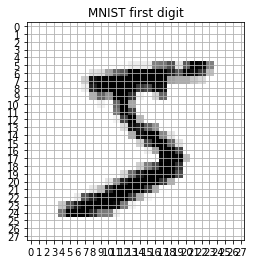

In [17]:
rcParams['figure.figsize'] = 4, 4
# Invert grey values for imshow()
inverted = np.array(np.asarray([255] * len(mnist_data.iloc[0])) - mnist_data.iloc[0])
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST first digit")
print("Label: %s" % (mnist_labels[0]))
plt.show()

Markov Clustering on HSNE scale 2, 1765 datapoints:

note that Markov clustering can take very long on larger matrices

In [18]:
result = mc.run_mcl(hsne[2].tmatrix, verbose=False, inflation=1.1)           # run MCL with default parameters
cluster_tuples = mc.get_clusters(result)    # get clusters


In [19]:
clusters = [[c] * len(cluster) for c, cluster in enumerate(cluster_tuples)]
clusters = dict(zip(np.hstack(cluster_tuples), np.hstack(clusters)))
clusters = {hsne[2].lm_to_original[key]:value for key, value in clusters.items()}

Calculate rand index of clustering versus labels:

In [20]:
adjusted_rand_score(list(clusters.values()), mnist_labels[list(clusters.keys())])

0.9978234054948103

Clustering is almost perfect; contingency matrix of clustering shows 1 error:

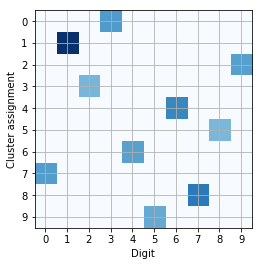

In [21]:
rcParams['figure.figsize'] = 4, 4
landmark_truth = mnist_labels[list(clusters.keys())]
plt.imshow(contingency_matrix(list(clusters.values()), landmark_truth), cmap='Blues')
plt.xticks([i for i in range(10)])
plt.yticks([ i for i in range(10)])
plt.ylabel("Cluster assignment")
plt.xlabel("Digit")
plt.grid(b=True)
plt.show()

In [22]:
# A 5 ended up in the 3 cluster
wrong_label = mnist_labels[np.array(hsne[2].lm_to_original)[list(cluster_tuples[0])]]
print(wrong_label)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [23]:
# This is landmark #
np.argmax(wrong_label)

123

In [24]:
# This is original datapoint #
np.array(hsne[2].lm_to_original)[list(cluster_tuples[0])][123]

43454

### This digit was clearly incorrectly labeled!
Clustering a higher scale is sensitive enough to recognize a labeling error

Label: 5


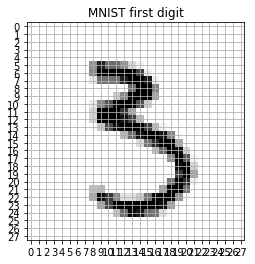

In [25]:
rcParams['figure.figsize'] = 4, 4
inverted = np.array(np.asarray([255] * len(mnist_data.iloc[43454])) - mnist_data.iloc[43454])
plt.imshow(inverted.reshape(28, 28), cmap='gray')
plt.xticks([i for i in range(28)])
plt.yticks([i for i in range(28)])
plt.grid(b=True)
plt.title("MNIST first digit")
print("Label: %s" % (mnist_labels[43454]))
plt.show()

Generate 2D embeddings (may take a few minutes):

In [26]:
import umap

embedding = umap.UMAP().fit_transform(mnist_data)


In [27]:
import matplotlib.pyplot as plt
X = embedding.T[0]
Y = embedding.T[1]

Plot umap embeddings overlaid with ground truth color, cluster number is maxmimum number of ground truth labels in that cluster

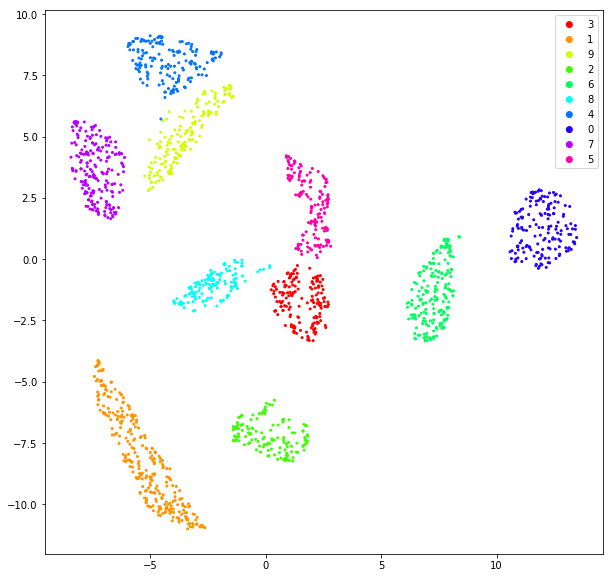

In [28]:
import matplotlib.cm as cm
rcParams['figure.figsize'] = 10, 10
for c, cluster in enumerate(cluster_tuples):
    digits = np.array(hsne[2].lm_to_original)[list(cluster)]
    clabels = mnist_labels[digits]
    u, indices = np.unique(clabels, return_inverse=True)
    
    plt.scatter(x=X[digits], y=Y[digits], c=[cm.hsv(c/10)] * len(digits), label=str(u[np.argmax(np.bincount(indices))]), s=4)
plt.legend(markerscale=3)
plt.show()


In [29]:
results = hsne.get_datascale_mappings(2)
results

{0: 312,
 1: 583,
 2: 184,
 3: 1,
 4: 282,
 5: 1024,
 6: 1265,
 7: 478,
 8: 145,
 9: 1253,
 10: 719,
 11: 416,
 12: 1166,
 13: 773,
 14: 1318,
 15: 750,
 16: 1207,
 17: 1556,
 18: 823,
 19: 754,
 20: 61,
 21: 583,
 22: 699,
 23: 1540,
 24: 715,
 25: 908,
 26: 1377,
 27: 330,
 28: 395,
 29: 350,
 30: 569,
 31: 592,
 32: 1254,
 33: 754,
 34: 1069,
 35: 424,
 36: 884,
 37: 149,
 38: 1530,
 39: 940,
 40: 1336,
 41: 917,
 42: 1514,
 43: 754,
 44: 104,
 45: 1148,
 46: 1678,
 47: 1579,
 48: 496,
 49: 895,
 50: 1249,
 51: 844,
 52: 989,
 53: 1563,
 54: 512,
 55: 546,
 56: 844,
 57: 721,
 58: 612,
 59: 431,
 60: 193,
 61: 1563,
 62: 225,
 63: 215,
 64: 1267,
 65: 351,
 66: 1506,
 67: 347,
 68: 1140,
 69: 857,
 70: 969,
 71: 1228,
 72: 82,
 73: 265,
 74: 2,
 75: 583,
 76: 908,
 77: 1762,
 78: 869,
 79: 1306,
 80: 336,
 81: 864,
 82: 1650,
 83: 720,
 84: 291,
 85: 210,
 86: 1166,
 87: 476,
 88: 927,
 89: 1070,
 90: 117,
 91: 642,
 92: 1399,
 93: 500,
 94: 803,
 95: 1355,
 96: 293,
 97: 66,
 98: 2

In [30]:
# Which cluster does each datascale's point best representative belond to?
clusters = [[c] * len(cluster) for c, cluster in enumerate(cluster_tuples)]
clusters = dict(zip(np.hstack(cluster_tuples), np.hstack(clusters)))
datascale_clustering = {}
for key, value in results.items():
    datascale_clustering[key] = clusters[value]
datascale_clustering

{0: 9,
 1: 7,
 2: 6,
 3: 1,
 4: 2,
 5: 3,
 6: 1,
 7: 0,
 8: 1,
 9: 6,
 10: 0,
 11: 9,
 12: 0,
 13: 4,
 14: 1,
 15: 8,
 16: 3,
 17: 5,
 18: 4,
 19: 2,
 20: 6,
 21: 7,
 22: 2,
 23: 1,
 24: 3,
 25: 3,
 26: 6,
 27: 0,
 28: 3,
 29: 8,
 30: 3,
 31: 5,
 32: 4,
 33: 2,
 34: 7,
 35: 9,
 36: 4,
 37: 7,
 38: 8,
 39: 4,
 40: 1,
 41: 5,
 42: 8,
 43: 2,
 44: 0,
 45: 2,
 46: 5,
 47: 9,
 48: 0,
 49: 0,
 50: 0,
 51: 7,
 52: 8,
 53: 6,
 54: 2,
 55: 5,
 56: 7,
 57: 2,
 58: 6,
 59: 1,
 60: 6,
 61: 6,
 62: 4,
 63: 7,
 64: 6,
 65: 9,
 66: 4,
 67: 1,
 68: 7,
 69: 7,
 70: 1,
 71: 8,
 72: 1,
 73: 4,
 74: 0,
 75: 7,
 76: 3,
 77: 1,
 78: 1,
 79: 8,
 80: 7,
 81: 7,
 82: 3,
 83: 4,
 84: 8,
 85: 5,
 86: 0,
 87: 2,
 88: 7,
 89: 6,
 90: 4,
 91: 8,
 92: 6,
 93: 4,
 94: 5,
 95: 7,
 96: 8,
 97: 5,
 98: 0,
 99: 1,
 100: 9,
 101: 8,
 102: 1,
 103: 8,
 104: 1,
 105: 1,
 106: 4,
 107: 0,
 108: 7,
 109: 3,
 110: 2,
 111: 0,
 112: 1,
 113: 1,
 114: 7,
 115: 6,
 116: 2,
 117: 3,
 118: 7,
 119: 7,
 120: 8,
 121: 7,
 122: 3,
 12

How well does the datascale clustering agree with the ground truth labels?
It's gotten worse but is still of high quality.

In [31]:
adjusted_rand_score(mnist_labels, list(datascale_clustering.values()))

0.8928962853528924

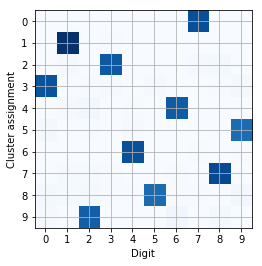

In [32]:
rcParams['figure.figsize'] = 4, 4
landmark_truth = mnist_labels[list(clusters.keys())]
plt.imshow(contingency_matrix(mnist_labels, list(datascale_clustering.values())), cmap='Blues')
plt.xticks([i for i in range(10)])
plt.yticks([ i for i in range(10)])
plt.ylabel("Cluster assignment")
plt.xlabel("Digit")
plt.grid(b=True)
plt.show()

Umap embeddings off all datapoints overlaid with scale 2 cluster assignments propagated down to the datascale

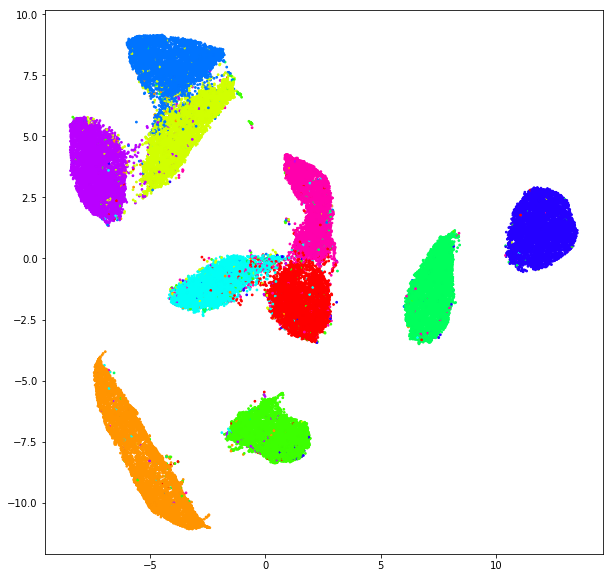

In [33]:
import matplotlib.cm as cm
rcParams['figure.figsize'] = 10, 10
plt.scatter(x=X, y=Y, c=[cm.hsv(c/10) for c in datascale_clustering.values()], s=3)

plt.show()
